<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S11/resnet_model_album_cam__ocp_90_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mounting Google Colab and importing generic Packages
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,PadIfNeeded,
    Transpose, RandomCrop ,ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks\resnet')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#importing self-created packages:
import ocp_train as t                                                         #import train - test module .This is class to train and evaluate the model
import load as ld                                                               #dataloader
import mod_summ as m                                                            #Getting model summary package
import resnet_s11 as bb                                                         #Getting Classes for Resnet and Basic Block
import s11_album as al                                                          #Getting albumentation module
import override_album as oa                                                     # overriding the albumentation class
import GradCm as gd                                                             #Grad Cam Module
import plot_cam   as pt                                                         #Plotting Image with Gradcam
import lr_update  as lr                                                         #exponential LR update
torch.cuda.empty_cache()


In [0]:
net=bb.Net().to('cuda') 
m.summ_print(net,(3,32,32))# Model summary.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

In [0]:
train_transforms,test_transforms=al.album_transform(albumentations)             #Albumentation class 

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = oa.PyTorchImageDataset(image=trainset, augmentations=train_transforms)
test_ds =  oa.PyTorchImageDataset(image=testset, augmentations=test_transforms)

In [0]:
batch_size=512
trainloader,testloader=ld.load_test_train(batch_size,train_ds,test_ds,torchvision,torch)

In [0]:
def range_test(end_lr=3,num_iter=100,step_mode="exp", smooth_f=0.05, diverge_th=5):
        if step_mode.lower() == "exp":
            lr_schedule = lr.ExponentialLR(optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = lr.LinearLR(optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")
        return lr_schedule

In [0]:
train_losses = []
test_losses = []
train_acc = 0
test_acc = []
train_acc_graph=[]
history = {"lr": [], "loss": []}
getlr=0.0001
optimizer = optim.SGD(net.parameters(),lr=getlr,momentum=0.9)                               # start LR is 0.00001
lr_schedule=range_test(end_lr=3,num_iter=100,step_mode="linear",smooth_f=0.04,diverge_th=3)
criterion=nn.CrossEntropyLoss()
best_loss = None
diverge_th=3
num_iter=1000
smooth_f=0.05
b=0
device='cuda'
lr2=[]
#EPOCHS =1
#for epoch in range(EPOCHS):
#print("EPOCH:", epoch)
best_lrn,best_loss,history,train_acc1,b=t.train(net, device, trainloader,lr_schedule ,optimizer,train_losses,train_acc,tqdm,criterion, smooth_f, diverge_th)
lr2.append(max(history["lr"]))
train_acc_graph.append(train_acc1) 
print(lr2)
 
 

   

  4%|▍         | 4/98 [00:01<00:33,  2.77it/s]

Stopping early, the loss has diverged


  4%|▍         | 4/98 [00:01<00:45,  2.08it/s]

[0.18009399999999998]


In [0]:
torch.cuda.empty_cache()
best_lrn


0.060098

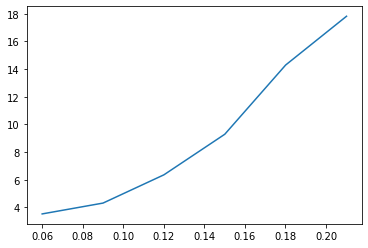

In [0]:
h=[1,2,3,4,5,6]
#max_lr1=lr2[train_acc_graph.index(max(train_acc_graph))]  
plt.plot(history["lr"],history["loss"])
net1=bb.Net().to('cuda')      
                                    # Creating new model for final training.

In [0]:
net1=bb.Net().to('cuda') 


In [0]:
len(trainloader)

98

In [0]:
import train_test_model_resnet18_missclass as t1                                   #import train - test module .This is class to train and evaluate the model
train_losses = []
test_acc = []
max_lr=best_lrn
test_losses = []
train_acc = []
train_loss_graph=[]
train_acc_graph=[]
test_acc_graph=[]
test_loss_graph=[]
EPOCHS = 24
optimizer = optim.SGD(net1.parameters(),lr=0.0001,weight_decay=0.0022,momentum=0.90)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,steps_per_epoch=len(trainloader),pct_start=0.208,epochs=24,div_factor=10,anneal_strategy='linear',cycle_momentum=True,
                                              max_momentum=0.95,base_momentum=0.85)
lr=[]
device='cuda'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss,train_acc1=t1.train(net1, device, trainloader, optimizer, epoch,train_losses,train_acc,tqdm,criterion,scheduler)
    train_loss_graph.append(train_loss)
    train_acc_graph.append(train_acc1)
    test_loss,test_acc1=t1.test(net1, device, testloader,test_losses,test_acc,tqdm,criterion,torch)
    test_loss_graph.append(test_loss)    
    test_acc_graph.append(test_acc1)
    #scheduler.step(test_loss)
    for param_group in optimizer.param_groups:
       print(param_group['lr'])
      

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.294288396835327 Batch_id=97 Accuracy=22.84: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 3069/10000 (30.69%)

0.016866968958002198
EPOCH: 1


Loss=2.369321584701538 Batch_id=97 Accuracy=34.68: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 3628/10000 (36.28%)

0.027724137916004393
EPOCH: 2


Loss=1.629914402961731 Batch_id=97 Accuracy=39.98: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4705/10000 (47.05%)

0.03858130687400659
EPOCH: 3


Loss=1.3543589115142822 Batch_id=97 Accuracy=50.37: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5612/10000 (56.12%)

0.04943847583200879
EPOCH: 4


Loss=1.0402330160140991 Batch_id=97 Accuracy=58.59: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 5846/10000 (58.46%)

0.06004044434145253
EPOCH: 5


Loss=0.8168097734451294 Batch_id=97 Accuracy=65.44: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6789/10000 (67.89%)

0.056878754578194954
EPOCH: 6


Loss=0.7278291583061218 Batch_id=97 Accuracy=70.88: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7395/10000 (73.95%)

0.05371706481493738
EPOCH: 7


Loss=0.6229115724563599 Batch_id=97 Accuracy=75.52: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7111/10000 (71.11%)

0.050555375051679806
EPOCH: 8


Loss=0.5393973588943481 Batch_id=97 Accuracy=77.91: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7812/10000 (78.12%)

0.04739368528842223
EPOCH: 9


Loss=0.47088199853897095 Batch_id=97 Accuracy=80.84: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8089/10000 (80.89%)

0.04423199552516466
EPOCH: 10


Loss=0.5016626715660095 Batch_id=97 Accuracy=82.82: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7786/10000 (77.86%)

0.04107030576190708
EPOCH: 11


Loss=0.5007922053337097 Batch_id=97 Accuracy=84.73: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8140/10000 (81.40%)

0.0379086159986495
EPOCH: 12


Loss=0.45676812529563904 Batch_id=97 Accuracy=85.91: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8208/10000 (82.08%)

0.034746926235391926
EPOCH: 13


Loss=0.41906052827835083 Batch_id=97 Accuracy=87.30: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8363/10000 (83.63%)

0.03158523647213435
EPOCH: 14


Loss=0.29634565114974976 Batch_id=97 Accuracy=88.51: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8470/10000 (84.70%)

0.028423546708876778
EPOCH: 15


Loss=0.2580670416355133 Batch_id=97 Accuracy=89.50: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8605/10000 (86.05%)

0.0252618569456192
EPOCH: 16


Loss=0.29773351550102234 Batch_id=97 Accuracy=90.60: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8582/10000 (85.82%)

0.022100167182361623
EPOCH: 17


Loss=0.2694152295589447 Batch_id=97 Accuracy=91.32: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8612/10000 (86.12%)

0.018938477419104052
EPOCH: 18


Loss=0.18985816836357117 Batch_id=97 Accuracy=92.94: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8726/10000 (87.26%)

0.015776787655846475
EPOCH: 19


Loss=0.1844872683286667 Batch_id=97 Accuracy=93.31: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8666/10000 (86.66%)

0.012615097892588904
EPOCH: 20


Loss=0.19104689359664917 Batch_id=97 Accuracy=94.43: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8823/10000 (88.23%)

0.00945340812933132
EPOCH: 21


Loss=0.10423426330089569 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8921/10000 (89.21%)

0.006291718366073749
EPOCH: 22


Loss=0.11768893897533417 Batch_id=97 Accuracy=96.55: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8979/10000 (89.79%)

0.003130028602816172
EPOCH: 23


Loss=0.09038981795310974 Batch_id=97 Accuracy=97.62: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.0006, Accuracy: 9054/10000 (90.54%)

-3.166116044139855e-05


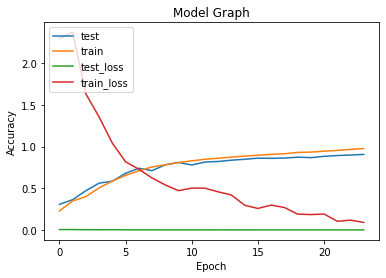

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(test_acc_graph)                
plt.plot(train_acc_graph)
plt.plot(test_loss_graph)
plt.plot(train_loss_graph)         
plt.title("Model Graph")            
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['test','train','test_loss','train_loss'] ,loc='upper left')
plt.show()  
plt.savefig('Upload_graph.png')           

In [0]:
cam2=[]
data2=[]
k=[]
dat=[]
number=0
p=[]
l=[]
data2=[]
for im in range(25):
  
  dat1,label = next(iter(testloader))
  dat1=dat1.to('cuda')
  output=net(dat1)
  pred = output.argmax(dim=1, keepdim=True)
  
  for i in range(label.size()[0]):
   if pred[i].item() != label[i].item():
    p.append(pred[i].item()) 
    l.append(label[i].item()) 
    label1=label[i]
    data1=dat1[i]
    data2.append(dat1[i].to('cpu'))
    label1=label1.unsqueeze(0) 
    Gd1=gd.GradCm()
    cam1=Gd1.img(data1,label1,net)
    cam2.append(cam1) 
    number = len(cam2)
    if number >= 25:
        print(number)
        break
  else:
   continue
  break 

In [0]:
plott=pt.Plot()
#l=l.to('cpu')
#data2=data2.to('cpu')
plott.fig(data2,cam2,l,p)


fgfghfhfgfhhggdrfrrfdsvfgdffdv          